<a href="https://colab.research.google.com/github/YanivAmir/stock-predicition-CNN/blob/main/stocks_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# !pip install yahoo_fin
# !pip install mplfinance

In [1]:
# import yfinance as yf
# import yahoo_fin.stock_info as si
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
# import mplfinance as mpf
from datetime import datetime
from collections import Counter
import pandas as pd #pip install pandas==1.3.0
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import logging
import re
import seaborn as sns
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import warnings
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,TensorDataset
from torchsummary import summary

warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



*   loading and unzipping the data
*   uniting images into two channel images
*   visualize a random sample
*   create train and validation and test datasets
*   create cnn
*   test run on a single batch
*   create training function
*   train model
*   plot results


In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
def loadSingleDataFile(path, name,strt,end):
  data = np.load(path+name+'_asList_'+str(strt)+'-'+str(end)+'_24Sept2024.npz')
  data_array = np.array([data[key] for key in data])
  return(torch.from_numpy(data_array).float())

def loadAllData(path,strts,pool=1):
  images_list,labels_list = [],[]
  for strt,end in zip(strts[:-1],strts[1:]):
    print(strt)
    stockImgs = F.avg_pool2d(loadSingleDataFile(path,'StockImgs',strt,end),pool)
    capImgs = F.avg_pool2d(loadSingleDataFile(path,'CapImgs',strt,end),pool)
    print(stockImgs.shape)
    print(capImgs.shape)
    images = torch.cat((stockImgs.unsqueeze(1), capImgs.unsqueeze(1)), dim=1)
    labels = loadSingleDataFile(path,'Targets',strt,end)
    images_list.append(images)
    labels_list.append(labels)
  images = torch.cat((images_list), dim=0)
  labels = torch.cat((labels_list), dim=0)
  return(images,labels)


In [ ]:
2000,1594,841,811,638,456,1526,271,1342,118,1174,1000,0
2167,1851,999,841,811,638,1594,456,1526,271,1342,1174,118

[0,118,271,456,638,811,841,999]
[1000,1174,1342,1526,1594,1851,1999]
[2000,2167,2291,2499]
[2500,]
[3000,]

In [ ]:
savePath ='/content/drive/MyDrive/myStocksSept2024/'

frstIndx = [0,118,271,456,638,811,841,999]
scndIdx = [1000,1174,1342,1526,1594,1851,1999]
thrdIdx = [2000,2291,2499]
frthIdx = [2500,2678]
ffthIdx = [3000,3500]
allIndx = [0,118,271,456,638,811,841,1000,1174,1342,1526,1594,1851,2000]#,2291,2500,2678]

images,labels= loadAllData(savePath,allIndx,pool=2)
# currentImages,currentLabels= loadAllData(savePath,scndIdx,pool=2)
# # for startIndx in [scndIdx,thrdIdx]: #,frthIdx,ffthIdx]:
# images = torch.cat((images, currentImages), dim=0)
# labels = torch.cat((labels, currentLabels), dim=0)
print(images.shape)
print(labels.shape)

In [13]:
torch.save(labels, savePath+'labels_stocks0-2000_images0-54383_pool3.pt')
torch.save(images, savePath+'images_stocks0-2000_images0-54383_pool3.pt')

In [3]:
savePath ='/content/drive/MyDrive/myStocksSept2024/'
images = torch.load(savePath+'images_stocks0-2000_images0-54383_pool3.pt')
labels = torch.load(savePath+'labels_stocks0-2000_images0-54383_pool3.pt')
images = images.float()
labels = labels.float()
print(images.shape)
print(labels.shape)

torch.Size([54383, 2, 106, 106])
torch.Size([54383])


In [58]:
print(f'percent of positive movement instances in dataset: {round((sum(labels>0.1)/len(labels)).detach().item()*100,2)} %')


percent of positive movement instances in dataset: 46.46 %


In [ ]:
# for BCE net
labels01 = torch.zeros_like(labels)
labels01[labels>0.1]=1
labels = labels01

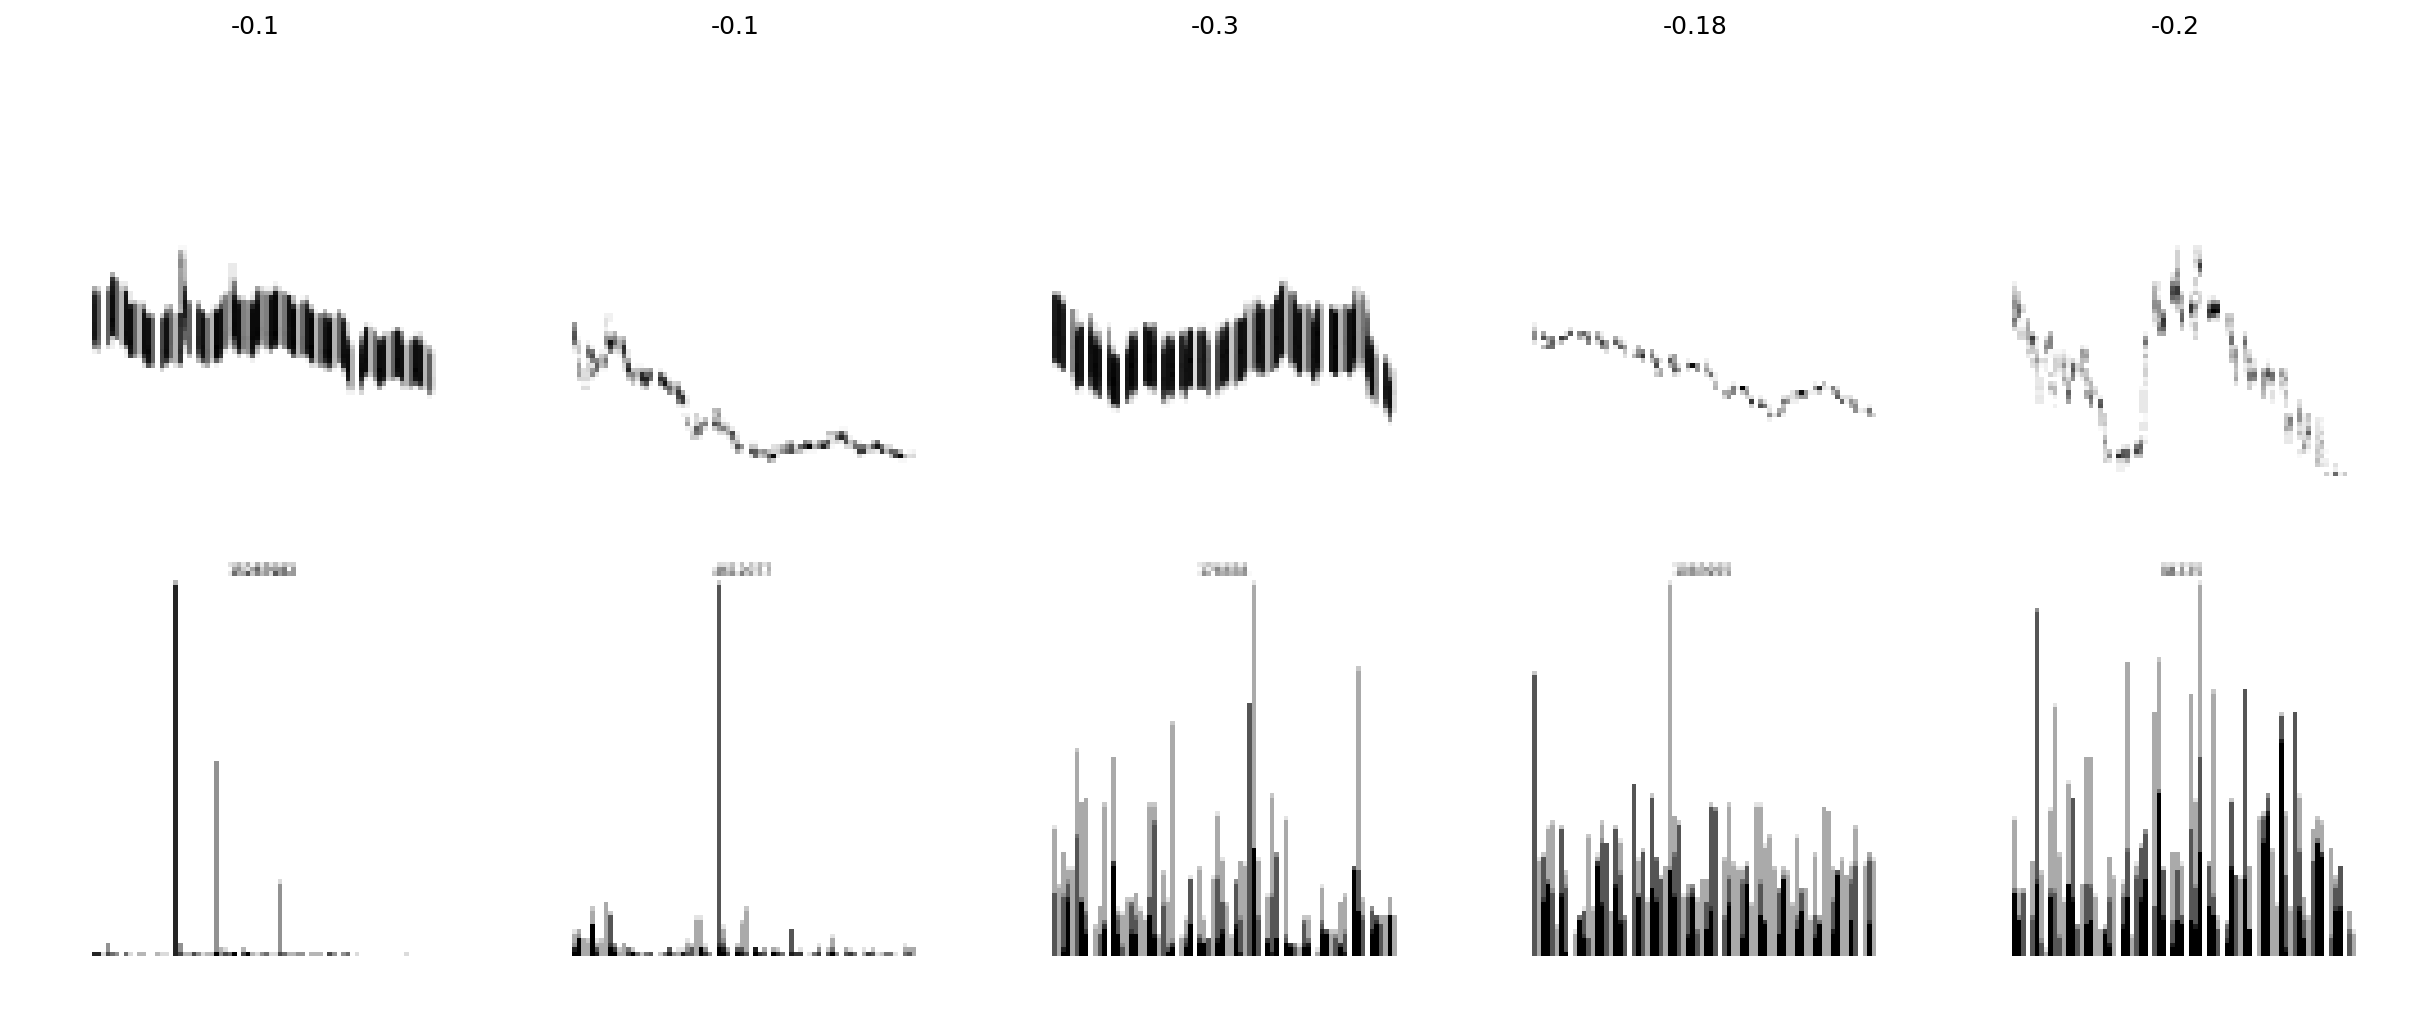

In [4]:
# visualize some images
fig,axs = plt.subplots(2,5,figsize=(5*320/100,2*320/100),dpi=150)

for i in range(axs.shape[1]):

  # pick a random pic
  n = np.random.randint(images.shape[0])

  # visualize
  axs[0,i].imshow(images[n,0,:,:],cmap='gray', aspect='auto')
  axs[1,i].imshow(images[n,1,:,:],cmap='gray', aspect='auto')
  axs[0,i].set_title('%s'%round(labels[n].item(),2))
  axs[0,i].axis('off')
  axs[1,i].axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

In [5]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.2)
dev_data,test_data, dev_labels,test_labels = train_test_split(test_data, test_labels, test_size=.5)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
dev_data = TensorDataset(dev_data,dev_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 24
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(dev_data,batch_size=batchsize)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [7]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([43506, 2, 106, 106])
torch.Size([43506])


In [ ]:
# test_data, test_loader = [],[]

In [38]:
# create a class for the model
def makeMSENet(printtoggle=False):

  class stockCNN(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(2,16,4,padding=1)
      self.bnorm1 = nn.BatchNorm2d(16) # input the number of channels in this layer
      # output size: (106+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(16,64,4,padding=1)
      self.bnorm2 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: (16+2*1-3)/1 + 1 = 16/2 = 8 (/2 b/c maxpool)

            # second convolution layer
      self.conv3  = nn.Conv2d(64,256,4,padding=1)
      self.bnorm3 = nn.BatchNorm2d(256) # input the number of channels in this layer
      # output size: (8+2*1-3)/1 + 1 = 14/2 = 4 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(36864,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64,1)

    #   self.to_half_precision()

    # def to_half_precision(self):
    #     # Convert all biases to float16
    #     for module in self.modules():
    #         if hasattr(module, 'bias') and module.bias is not None:
    #             module.bias = module.bias.half()


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Reshaped: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = F.tanh(self.fc3(x))
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = stockCNN(printtoggle)

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=0.0001)

  return net,lossfun,optimizer

In [ ]:
# create a class for the model
def makeBCENet(printtoggle=False):

  class stockCNN(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(2,16,4,padding=1)
      self.bnorm1 = nn.BatchNorm2d(16) # input the number of channels in this layer
      # output size: (106+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(16,64,4,padding=1)
      self.bnorm2 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: (16+2*1-3)/1 + 1 = 16/2 = 8 (/2 b/c maxpool)

            # second convolution layer
      self.conv3  = nn.Conv2d(64,256,4,padding=1)
      self.bnorm3 = nn.BatchNorm2d(256) # input the number of channels in this layer
      # output size: (8+2*1-3)/1 + 1 = 14/2 = 4 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(36864,256)
      self.fc2 = nn.Linear(256,64)
      self.fc3 = nn.Linear(64,1)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x,p=.1,training=self.training)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Reshaped: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = stockCNN(printtoggle)

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=0.0001)

  return net,lossfun,optimizer

In [11]:
# test the model with one batch
net,lossfun,optimizer = makeMSENet(True)
# net.half()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

imgSize = images.shape[2]
summary(net,(1,imgSize,imgSize))

Input: [24, 2, 106, 106]
First CPR block: [24, 16, 52, 52]
Second CPR block: [24, 64, 25, 25]
Second CPR block: [24, 256, 12, 12]
Reshaped: [24, 36864]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (24x36864 and 43200x256)

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeBCENet(True)
# net.half()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

imgSize = images.shape[2]
summary(net,(1,imgSize,imgSize))

In [39]:
# a function that trains the model

def function2trainMSEModel():

  # number of epochs
  numepochs = 20

  # create a new model
  net,lossfun,optimizer = makeTheNet(False)

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  trainLoss = []
  devLoss  = torch.zeros(numepochs)
  # trainErr  = torch.zeros(numepochs)
  # devErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())

    # end of batch loop...

    # and get average losses and error rates across the batches
    #trainLoss[epochi] = np.mean(batchLoss)
    trainLoss+=batchLoss
    # trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # extract the loss for this test epoch
    devLoss[epochi] = loss.item()

  # end epochs

  # function output
  return trainLoss,devLoss,net

In [ ]:
# a function that trains the model

def function2trainBCEModel():

  # number of epochs
  numepochs = 3

  # create a new model
  net,lossfun,optimizer = makeBCENet(False)

  # send the model to the GPU
  net.to(device)

  # initialize losses
  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc   = torch.zeros(numepochs)
  # trainErr  = torch.zeros(numepochs)
  # devErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    ### test performance
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # extract the loss for this test epoch
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

In [40]:

trainLoss,devLoss,net = function2trainMSEModel()

In [12]:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainBCEModel()

3

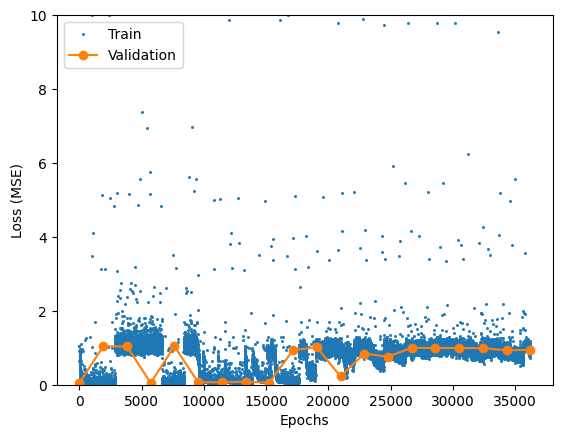

In [42]:
# X,y = next(iter(test_loader))
# X = X.to(device) # push data to GPU
# y = y.to(device) # push data to GPU
# yHat = net(X)
# test_loss = round(F.mse_loss(yHat,y),4)
# print(f'Test Loss : {test_loss:.4f}')
numepochs =20
plt.plot(trainLoss,'s',label='Train',markersize=1)
plt.plot(np.linspace(0,len(trainLoss),numepochs),devLoss,'o-',label='Validation')
# plt.plot(np.arange(len(trainLoss))[-1],'r*',label='Test')
plt.ylim((0,10))
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

plt.legend()
# plt.title('Model loss (final test loss: %.2f)'%testLoss[-1])

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

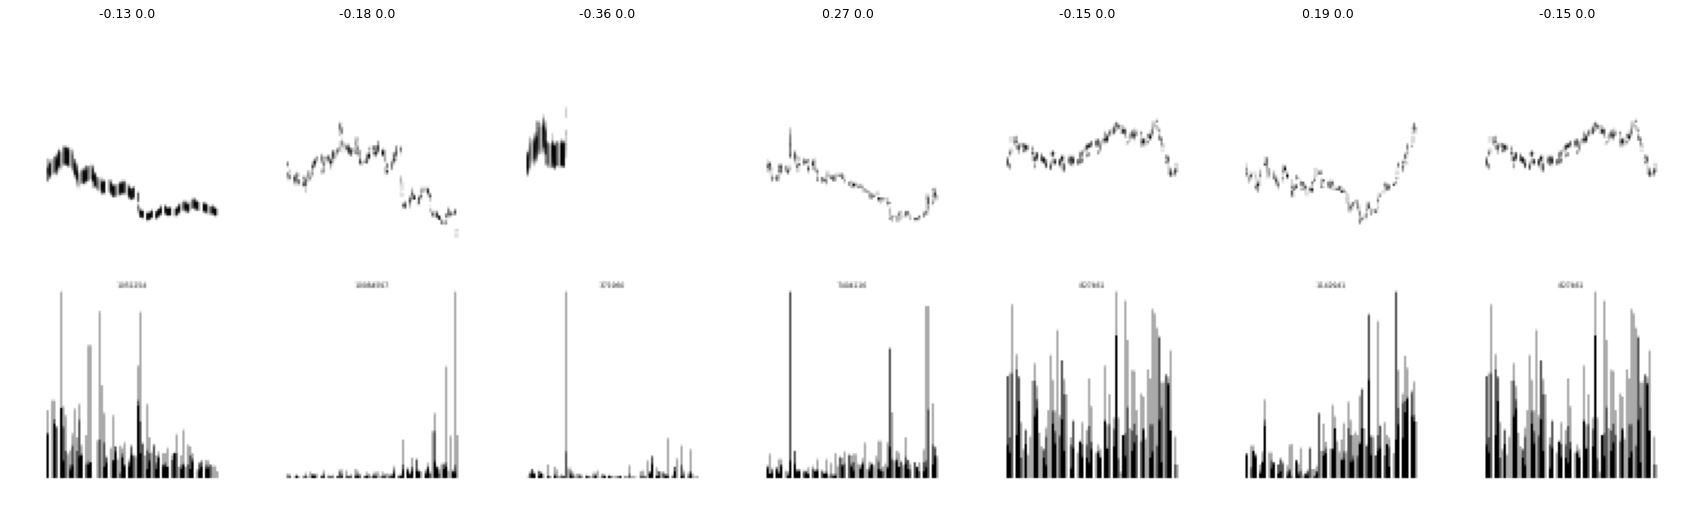

In [37]:
X,y = next(iter(dev_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = net(X)

# visualize some images
fig,axs = plt.subplots(2,7,figsize=(7*320/100,2*320/100),dpi=75)

for i in range(axs.shape[1]):

  # pick a random pic
  n = np.random.randint(X.cpu().shape[0])

  # visualize
  axs[0,i].imshow(torch.squeeze( X.cpu()[n,0,:,:] ).detach(),cmap='gray', aspect='auto')
  axs[1,i].imshow(torch.squeeze( X.cpu()[n,1,:,:] ).detach(),cmap='gray', aspect='auto')
  axs[0,i].set_title(f'{round(y.cpu()[n].item(),2)} {round(yHat.cpu()[n].item(),2)}')
  axs[0,i].axis('off')
  axs[1,i].axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

In [ ]:
# extract X,y from test dataloader
X,y = next(iter(test_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = net(X)
testErr = 100*torch.mean((torch.argmax(yHat.cpu(),axis=1) != y.cpu()).float()).item()
print(f'Test Error : {testErr:.2f}%')

numepochs = 10

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()


ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(devErr,'o-',label='Dev')
ax[1].plot(numepochs-1,testErr,'*',label='Test',markersize=15, color='r')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model dev error rate: {devErr[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# how much does it add in volume and time to increase img size?
# add noise?